<a href="https://colab.research.google.com/github/jungeun919/Pytorch_study/blob/main/CIFAR10_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transcription:

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Files already downloaded and verified
Files already downloaded and verified


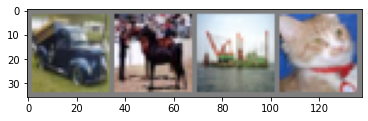

truck horse  ship   cat
[1,  2000] loss: 2.243
[1,  4000] loss: 1.883
[1,  6000] loss: 1.695
[1,  8000] loss: 1.580
[1, 10000] loss: 1.528
[1, 12000] loss: 1.480
[2,  2000] loss: 1.404
[2,  4000] loss: 1.414
[2,  6000] loss: 1.365
[2,  8000] loss: 1.359
[2, 10000] loss: 1.337
[2, 12000] loss: 1.300


In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


transform = transforms.Compose(
    [transforms.ToTensor(), #  [0, 1] 범위를 갖는 PILImage 이미지 -> [-1, 1]의 범위로 정규화된 Tensor로 변환
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader) # iter(호출 가능한 객체)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images)) # 이미지 보여주기
print(' '.join('%5s' % classes[labels[j]] for j in range(4))) # label 출력


# CNN 정의하기
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x


net = Net()

# 손실함수와 optimizer 정의하기
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


# 신경망 학습하기
for epoch in range(2):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data

    optimizer.zero_grad() # 변화도 매개변수를 0으로 만듦
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # 통계 출력
    running_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss / 2000))
      running_loss = 0.0

In [25]:
# 학습한 모델 저장
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

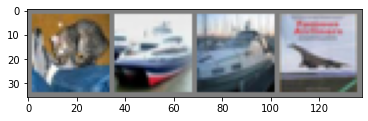

Testset_label:    cat  ship  ship plane


In [26]:
# testset으로 신경망 검사하기
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('Testset_label: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [27]:
# 저장한 모델 불러오기
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [28]:
# 신경망 예측 결과 확인하기
outputs = net(images)

_, predicted = torch.max(outputs, 1) # 가장 높은 값을 갖는 인덱스 추출
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car   car  ship


In [29]:
# 전체 dataset에서 동작 확인하기
correct = 0
total = 0
with torch.no_grad(): # 자동미분화(autograd)가 requires_grad=True인 Tensor들의 연산 기록을 추적하는 것을 멈출 수 있음
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [30]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze() # squeeze: 1인 차원 제거
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1


for i in range(10):
  print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 48 %
Accuracy of   car : 73 %
Accuracy of  bird : 47 %
Accuracy of   cat : 44 %
Accuracy of  deer : 31 %
Accuracy of   dog : 37 %
Accuracy of  frog : 72 %
Accuracy of horse : 47 %
Accuracy of  ship : 80 %
Accuracy of truck : 42 %


# Transcription (2)

Files already downloaded and verified
Files already downloaded and verified


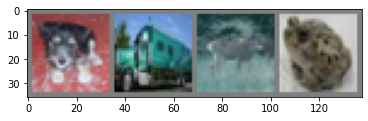

  dog truck  deer  frog
[1,  2000] loss: 2.182
[1,  4000] loss: 1.886
[1,  6000] loss: 1.697
[1,  8000] loss: 1.596
[1, 10000] loss: 1.542
[1, 12000] loss: 1.478
[2,  2000] loss: 1.420
[2,  4000] loss: 1.381
[2,  6000] loss: 1.376
[2,  8000] loss: 1.338
[2, 10000] loss: 1.296
[2, 12000] loss: 1.268
Finished Training

Verification with test set


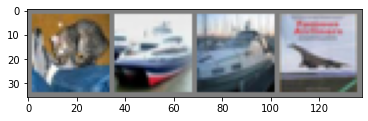

Testset_label:    cat  ship  ship plane


In [32]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def inshow(img):
  img = img / 2 + 0.5
  plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# CNN 구현
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x


net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


# 신경망 학습
for epoch in range(2):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss / 2000))
      running_loss = 0.0

print('Finished Training\n')


# 모델 저장
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


# testset으로 검사
print('Verification with test set')
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('Testset_label: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [36]:
# 저장한 모델 불러오기
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))


# 전체 데이터셋의 정확도
correct, total = 0, 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy 10000 test images: %d %%' % (100 * correct / total))


# 각 클래스의 정확도
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels.squeeze())
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1


for i in range(10):
  print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Predicted:    cat   dog  deer horse
Accuracy 10000 test images: 55 %
Accuracy of plane : 58 %
Accuracy of   car : 76 %
Accuracy of  bird : 28 %
Accuracy of   cat : 28 %
Accuracy of  deer : 34 %
Accuracy of   dog : 53 %
Accuracy of  frog : 71 %
Accuracy of horse : 68 %
Accuracy of  ship : 69 %
Accuracy of truck : 66 %
